In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras

In [2]:
print(tf.__version__)

2.4.1


# Ahsan Khan Submission for Extend AI

I considered lot of methods for solving this project I started off with an encoder-only approach but the output gives us exessive data, which is incorrect as there are a lot of edges which are highlighted on a wood panel. I figured you may as well have an accompying decoder to complete the U-net for an image segmentation model. 

Model was trained using GPU (CUDA) for experimenting but for submission purposes the training was done on just the CPU to avoid any imcompatibility errors incase you would like to run the notebook.

### Generation of bitmasks for training 

I manually labeled the 7 images using CVAT and tried to get near perfect masks as shown below. 

![SegmentLocal](gif_of_mask.gif "segment")

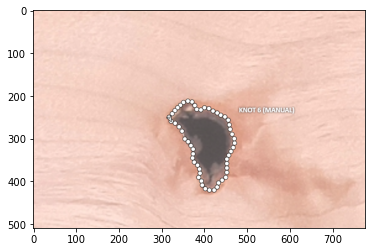

In [6]:
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('chrome_63fxYU2pQv.png'))

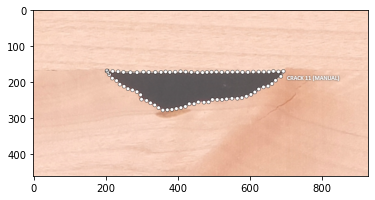

In [7]:
plt.imshow(mpimg.imread('chrome_B3JhoDkMmZ.png'))

### Constants

In [8]:
SEED = 567
BATCH_SIZE_TRAIN = 2
BATCH_SIZE_TEST = 2

# Number of training data
NUM_TRAIN = 5

# Number of validation data
NUM_TEST = 2

NUM_OF_EPOCHS = 100

### Helper Functions

In [9]:
# Function to display matching images next to each other
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.show()

In [20]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [21]:
# Function required to access image and masks from tensor generator
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

In [22]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

# Observing Data

Checking image data

Populating the interactive namespace from numpy and matplotlib


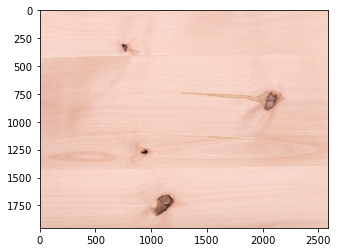

(1952, 2592, 3)


In [13]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('data/training/image/img/2021-04-07 21_39_06_exai_rpi_001_85.jpg')
imgplot = plt.imshow(img)
plt.show()
#print(np.unique(img))
print(img.shape)

Checking mask data

Populating the interactive namespace from numpy and matplotlib


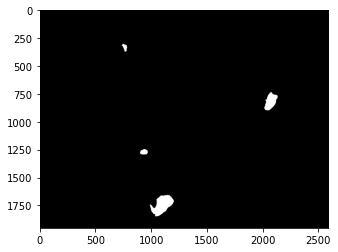

[0. 1.]
Correct Binary Labels
(1952, 2592, 3)


In [12]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('data/training/mask/img/2021-04-07 21_39_06_exai_rpi_001_85.png')
imgplot = plt.imshow(img)
plt.show()
print(np.unique(img))
print('Correct Binary Labels')
print(img.shape)

# Prepping data for Neural Network

In [15]:
# Main data directory
data_dir = 'data/'

data_dir_train = os.path.join(data_dir, 'training')
data_dir_train_image = os.path.join(data_dir_train, 'image')
data_dir_train_mask = os.path.join(data_dir_train, 'mask')


data_dir_val = os.path.join(data_dir, 'validation')
data_dir_val_image = os.path.join(data_dir_val, 'image')
data_dir_val_mask = os.path.join(data_dir_val, 'mask')

In [16]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=(384, 384), class_mode=None, batch_size=2, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=(384, 384), class_mode=None, batch_size=2, seed=SEED)
    return zip(img_generator, msk_generator)


def create_segmentation_generator_val(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=(384, 384), class_mode=None, batch_size=2, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=(384, 384), class_mode=None, batch_size=2, seed=SEED)
    return zip(img_generator, msk_generator)

In [17]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
validation_generator = create_segmentation_generator_val(data_dir_val_image, data_dir_val_mask, BATCH_SIZE_TEST)

Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


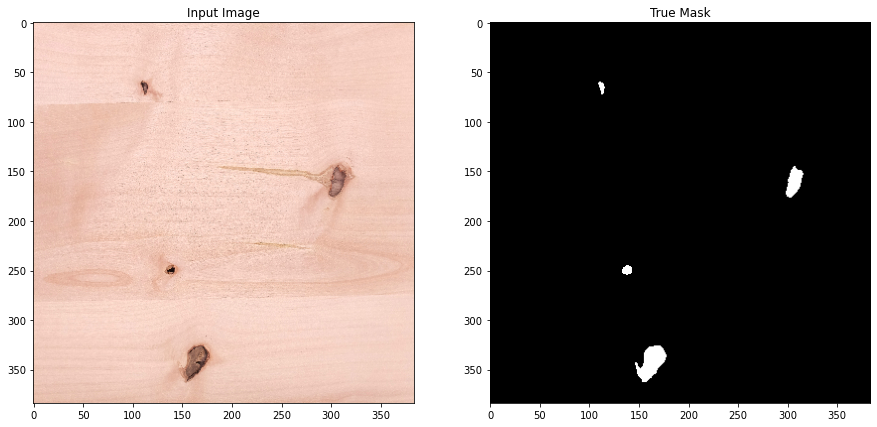

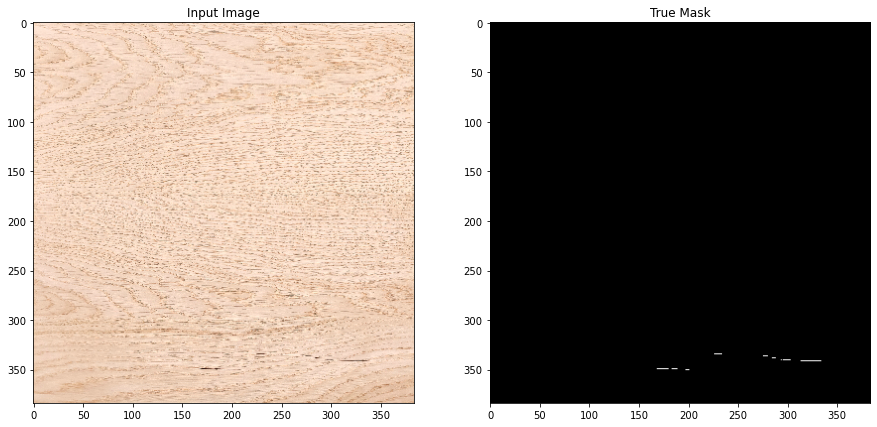

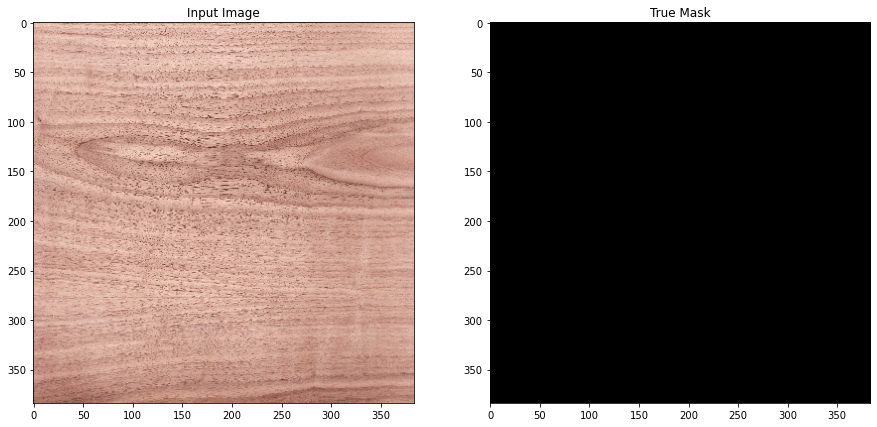

In [32]:
show_dataset(train_generator, 3)

# Neural Network (4 level U-net)

In [33]:
# Credits: Dennis Madsen 2D U-Net.
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=3, out_channels=1):
    inputs = keras.layers.Input(shape=(384, 384, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [34]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 384, 384, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 192, 192, 32) 0           conv2d_1[0][0]                   
________________________________________________________________________________________

# Training

In [35]:
history=model.fit(train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=validation_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS)

Epoch 1/100
2/2 [==============================] - 10s 7s/step - loss: 0.6297 - accuracy: 0.9836 - val_loss: 0.4399 - val_accuracy: 0.9947
Epoch 2/100
2/2 [==============================] - 8s 4s/step - loss: 0.4184 - accuracy: 1.0000 - val_loss: 0.1009 - val_accuracy: 0.9947
Epoch 3/100
2/2 [==============================] - 10s 6s/step - loss: 0.0700 - accuracy: 0.9986 - val_loss: 0.0920 - val_accuracy: 0.9947
Epoch 4/100
2/2 [==============================] - 8s 6s/step - loss: 7.2268e-04 - accuracy: 1.0000 - val_loss: 0.5514 - val_accuracy: 0.9947
Epoch 5/100
2/2 [==============================] - 7s 4s/step - loss: 0.3378 - accuracy: 0.9969 - val_loss: 0.1104 - val_accuracy: 0.9947
Epoch 6/100
2/2 [==============================] - 9s 5s/step - loss: 0.0209 - accuracy: 0.9986 - val_loss: 0.0481 - val_accuracy: 0.9947
Epoch 7/100
2/2 [==============================] - 9s 6s/step - loss: 0.0162 - accuracy: 0.9982 - val_loss: 0.0325 - val_accuracy: 0.9947
Epoch 8/100
2/2 [===========

# Analysis

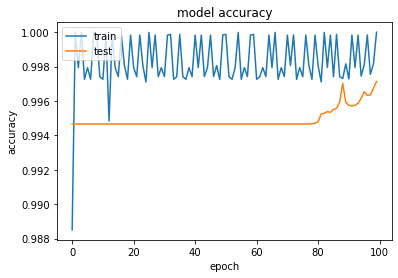

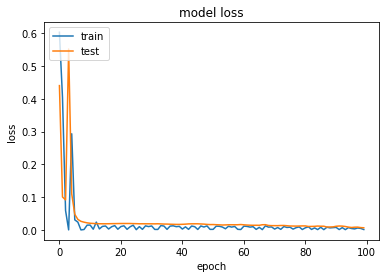

<Figure size 432x288 with 0 Axes>

In [36]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy_graph.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss_graph.png')

##### Trained on 10, 100 and then 1000 epochs and found 350 to be somewhat optimal for our data

# Testing

In [37]:
test_generator = create_segmentation_generator_val(data_dir_val_image, data_dir_val_mask, 1)

Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


In [38]:
# Function to test model prediction
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5 # Predicting
        display([image[0], mask[0], pred_mask])

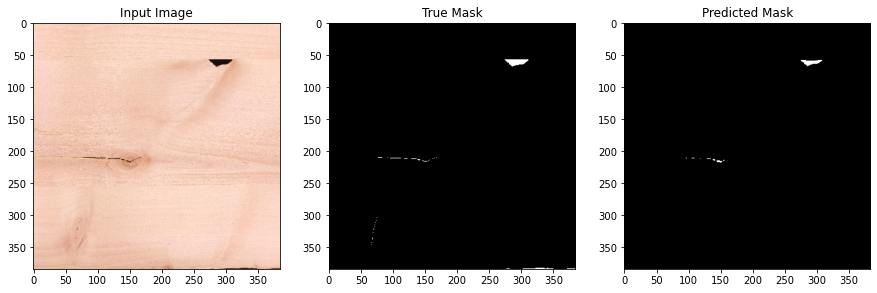

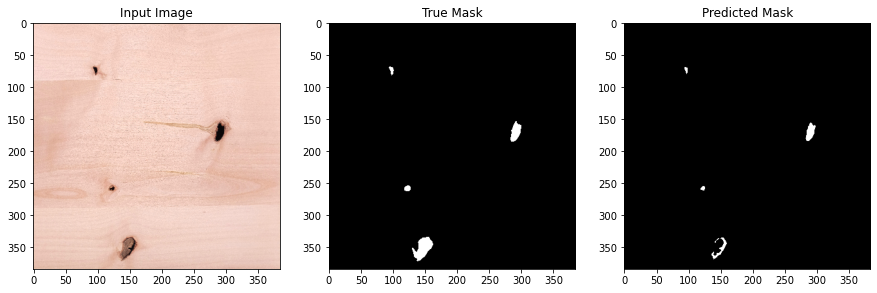

In [40]:
show_prediction(test_generator, 2)

The model is able to segment anomalies present on the surface albeit not complete predictions of cracks (yet)

There are many ways to improve results for training on 7 images such as transfer learning and application of data augmentation techniques. A combination of these two (using weights from pre-trained a model such as ResNet) would output complete segmentations and allow us to lower the number of epochs to rid of any over training.